In [28]:
# Import libraries
import numpy as np
import pandas as pd
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense, Dropout
from keras.models import load_model
# import keras
# import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
from datetime import datetime
# from pandas_datareader.data import DataReader
import yfinance as yf
# from pandas_datareader import data as pdr
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [35]:
# Define the path where the tokenizer and model are saved
load_directory = '/content/drive/MyDrive/Final Year Project/twitter_roberta_sentiment'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(load_directory)
model = AutoModelForSequenceClassification.from_pretrained(load_directory)

In [46]:
# Override how Pandas Datareader reads data
yf.pdr_override()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Define the list of stocks you want to download
stocks = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS',
          'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS',
          'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
          'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS',
          'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS',
          'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LTIM.NS', 'LT.NS',
          'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS',
          'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS',
          'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS',
          'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']

# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year, today.month-5, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)

2024-01-19 00:00:00
2024-06-19 00:00:00


In [47]:
# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

stock = 'TCS.NS'

# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

# Download data from Yahoo Finance
df = yf.download(stock, start=start, end=end)

# Ticker for searching news
stockraw = stock[:-3]

# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
soup = BeautifulSoup(webpage, 'html.parser')

# Extract titles and dates
titles = soup.find_all('a', class_='JtKRv')
datetimes = soup.find_all('time', class_='hvbAAd')

# Create lists to store extracted data
dates_list = []
titles_list = []

for title, datetime_tag in zip(titles, datetimes):
    # Remove leading/trailing whitespace from title
    title_text = title.text.strip()
    datetime_str = datetime_tag['datetime']

    # Parse datetime string
    formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')

    # Append data to respective lists
    dates_list.append(formatted_datetime.date())
    titles_list.append(title_text)

# Create DataFrame
df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)

# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

print(merged_df.tail(5))

# Isolating features for training
cols = list(merged_df)[1:8]

# Storing all data for scaling
df_for_scaling = merged_df[cols]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the numerical data
scaled_numerical_data = scaler.fit_transform(df_for_scaling)

# Create a new DataFrame for the scaled data
df_scaled = df_for_scaling.copy()
df_scaled[cols] = scaled_numerical_data

# Add a column for the stock ticker
df_scaled['Stock'] = stock

# Add all data to the following dataframe
all_stock_data = pd.concat([all_stock_data, df_scaled])

print(all_stock_data)

[*********************100%%**********************]  1 of 1 completed


         Date         Open         High          Low        Close  \
93 2024-06-11  3845.000000  3879.949951  3841.000000  3852.100098   
94 2024-06-12  3874.399902  3893.500000  3827.449951  3831.649902   
95 2024-06-13  3856.800049  3890.000000  3852.000000  3878.149902   
96 2024-06-14  3889.000000  3889.000000  3828.000000  3832.050049   
97 2024-06-18  3826.050049  3842.000000  3795.050049  3815.100098   

      Adj Close   Volume  Sentiments  
93  3852.100098  1419898    0.116931  
94  3831.649902  2177001   -0.103162  
95  3878.149902  1932323    0.080256  
96  3832.050049  1860730   -0.090365  
97  3815.100098  1774045   -0.129841  
        Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0   0.475497  0.428740  0.552605  0.496261   0.470495  0.213038    0.485292   
1   0.388161  0.370574  0.429120  0.341601   0.307924  0.181311    0.961494   
2   0.349345  0.271996  0.365671  0.311600   0.276387  0.185126    0.485292   
3   0.271518  0.227563  0.319727  0

In [48]:
df_for_training = all_stock_data.copy()

df_for_training

,Open,High,Low,Close,Adj Close,Volume,Sentiments,Stock
0,0.475497,0.428740,0.552605,0.496261,0.470495,0.213038,0.485292,TCS.NS
1,0.388161,0.370574,0.429120,0.341601,0.307924,0.181311,0.961494,TCS.NS
2,0.349345,0.271996,0.365671,0.311600,0.276387,0.185126,0.485292,TCS.NS
3,0.271518,0.227563,0.319727,0.254149,0.215999,0.140690,0.485292,TCS.NS
4,0.195633,0.147131,0.323399,0.237188,0.198169,0.085861,0.485292,TCS.NS
...,...,...,...,...,...,...,...,...
93,0.281417,0.264738,0.426132,0.330385,0.349808,0.063587,0.559216,TCS.NS
94,0.338476,0.291319,0.402989,0.293088,0.310318,0.137926,0.420073,TCS.NS
95,0.304318,0.284453,0.444919,0.377895,0.400112,0.113902,0.536029,TCS.NS
96,0.366812,0.282491,0.403928,0.293817,0.311091,0.106872,0.428163,TCS.NS


In [49]:
# Convert to DataFrame
df = pd.DataFrame(df_for_training)

# Define all possible categories for the 'Stock' column
all_categories = sorted(stocks)

# Convert the 'Stock' column to a categorical type with the specified categories
df['Stock'] = pd.Categorical(df['Stock'], categories=all_categories)

# One hot encoding using pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['Stock'], dummy_na=False)
print(df_encoded)

cols = list(df_encoded)[7:57]


# Ensure the columns are integer type (0 and 1) instead of boolean
df_encoded[cols] = df_encoded[cols].astype(int)

# Print the one hot encoded DataFrame
print(df_encoded)

        Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0   0.475497  0.428740  0.552605  0.496261   0.470495  0.213038    0.485292   
1   0.388161  0.370574  0.429120  0.341601   0.307924  0.181311    0.961494   
2   0.349345  0.271996  0.365671  0.311600   0.276387  0.185126    0.485292   
3   0.271518  0.227563  0.319727  0.254149   0.215999  0.140690    0.485292   
4   0.195633  0.147131  0.323399  0.237188   0.198169  0.085861    0.485292   
..       ...       ...       ...       ...        ...       ...         ...   
93  0.281417  0.264738  0.426132  0.330385   0.349808  0.063587    0.559216   
94  0.338476  0.291319  0.402989  0.293088   0.310318  0.137926    0.420073   
95  0.304318  0.284453  0.444919  0.377895   0.400112  0.113902    0.536029   
96  0.366812  0.282491  0.403928  0.293817   0.311091  0.106872    0.428163   
97  0.244639  0.190289  0.347652  0.262904   0.278360  0.098361    0.403206   

    Stock_ADANIENT.NS  Stock_ADANIPORTS.NS  Stock_A

In [56]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 'Sentiments']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)

In [57]:
# Dataset splitting
SPLIT = 1.00
(X_test, y_test) = singleStepSampler(df_encoded, 20)
print(X_test.shape)
print(y_test.shape)

(78, 20, 57)
(78, 7)


In [70]:
y_test

array([[0.74158195, 0.65602757, 0.7147737 , 0.65602757, 0.63843273,
        0.04137234, 0.48529161],
       [0.6074721 , 0.58462524, 0.66456037, 0.58462524, 0.56337857,
        0.10934724, 0.48529161],
       [0.52595827, 0.75898251, 0.64816396, 0.75898251, 0.74665403,
        0.21697276, 0.48529161],
       [0.83454634, 0.69514885, 0.77694262, 0.69514885, 0.67955505,
        0.1733791 , 0.48529161],
       [0.65211063, 0.6020428 , 0.66823228, 0.6020428 , 0.58168669,
        0.05959963, 0.48529161],
       [0.58030082, 0.79053422, 0.69598634, 0.79053422, 0.77981977,
        0.21485415, 0.48529161],
       [0.76778282, 0.81707132, 0.84970111, 0.81707132, 0.80771427,
        0.11457931, 0.48529161],
       [0.77438137, 0.77357306, 0.80794201, 0.77357306, 0.7619911 ,
        0.29460704, 0.48529161],
       [0.79029635, 0.7722052 , 0.84594372, 0.7722052 , 0.76055319,
        0.12479482, 0.48529161],
       [0.7860262 , 0.7473098 , 0.8273269 , 0.7473098 , 0.73438419,
        0.09592804, 0.4

In [58]:
# Load the model
multivariate_lstm = load_model("/content/drive/MyDrive/Final Year Project/multivariate_lstm_model3.h5")

# Verify the loaded model
multivariate_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 200)           206400    
                                                                 
 dropout_4 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               120400    
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 327507 (1.25 MB)
Trainable params: 327507 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 0s 19ms/step


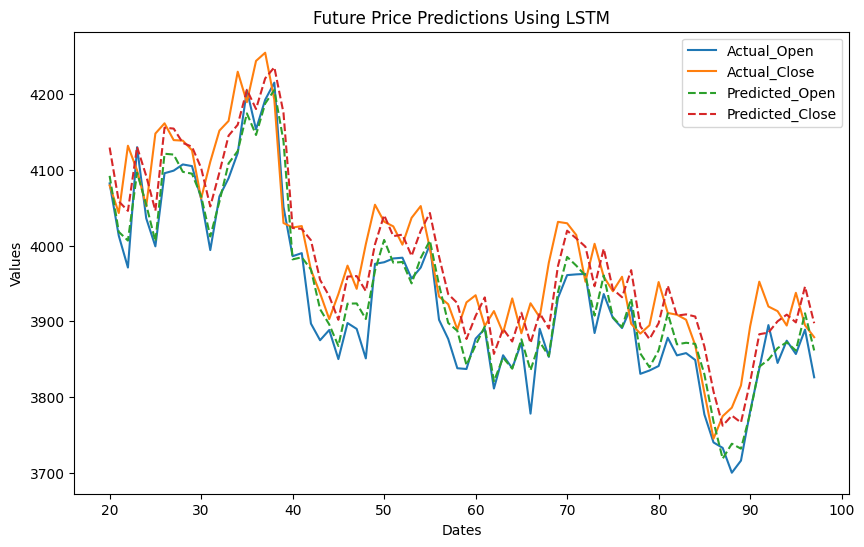

In [66]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test)
predicted_values_inv = scaler.inverse_transform(predicted_values)

# Create the DataFrame with inverse-transformed data
d = {
    'Predicted_Open': predicted_values_inv[:, 0],
    'Predicted_Close': predicted_values_inv[:, 1],
    'Actual_Open': y_test_inv[:, 0],
    'Actual_Close': y_test_inv[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
#plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])
plt.plot(d[['Actual_Open', 'Actual_Close']], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
#plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Future Price Predictions Using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [63]:
d.tail(5)

,Predicted_Open,Predicted_Close,Actual_Open,Actual_Close
93,3864.540039,3900.008301,3845.000000,3913.413786
94,3872.338623,3908.809570,3874.399902,3894.401409
95,3861.308105,3898.563232,3856.800049,3937.632073
96,3910.597900,3945.901123,3889.000000,3894.773422
97,3861.506104,3897.509766,3826.050049,3879.015194
